# **Εγκατάσταση και Εισαγωγή Βιβιλιοθηκών**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import pickle
import urllib.request
import tarfile
import os
from google.colab import drive
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

print("Libraries loaded successfully")

Libraries loaded successfully


# **Αποθήκευση Διαγραμμάτων στο Google Drive**


In [2]:
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/NeuralNetworks/Project1'
os.makedirs(save_path, exist_ok=True)

Mounted at /content/drive


# **Κατέβασμα και Φόρτωση CIFAR-10**

In [3]:
def download_cifar10():

    """
    Downloads CIFAR-10 dataset
    """

    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"

    if not os.path.exists(filename):
        print("Downloading CIFAR-10... (around 170MB)")
        urllib.request.urlretrieve(url, filename)
        print("Download completed!")

    # Decompression
    if not os.path.exists("cifar-10-batches-py"):
        print("Decompression...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
        print("Decompression completed!")

def load_cifar10_batch(file):

    """
    Loads a batch of CIFAR-10

    """

    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')

    # Conversion from bytes to strings for the keys
    data = batch[b'data']
    labels = batch[b'labels']

    # Reshape: (10000, 3072) -> (10000, 3, 32, 32) -> (10000, 32, 32, 3)
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return data, np.array(labels)

def load_cifar10(batch=5):

    """
    Loads the whole CIFAR-10 dataset
    parameters: batch: number of batches to load, default=5(the whole dataset)
    returns: traing data (X_train, y_train), test data (X_test, y_test), class names (class_names)
    """

    download_cifar10()

    # Training data
    X_train_list = []
    y_train_list = []

    if batch == 1:
      file = "cifar-10-batches-py/data_batch_1"
      X_batch, y_batch = load_cifar10_batch(file)
      X_train_list.append(X_batch)
      y_train_list.append(y_batch)
    else:
      for i in range(1, batch+1):
          file = f"cifar-10-batches-py/data_batch_{i}"
          X_batch, y_batch = load_cifar10_batch(file)
          X_train_list.append(X_batch)
          y_train_list.append(y_batch)

    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)

    # Test data
    X_test, y_test = load_cifar10_batch("cifar-10-batches-py/test_batch")

    # Class Names
    with open("cifar-10-batches-py/batches.meta", 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'label_names']]

    return X_train, y_train, X_test, y_test, class_names

# Φόρτωση δεδομένων
print("\n" + "="*60)
print("Data Loaded")
print("="*60)

X_train, y_train, X_test, y_test, class_names = load_cifar10()

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")
print(f"Image size: {X_train.shape[1]}x{X_train.shape[2]} pixels")
print(f"Classes: {class_names}")



Data Loaded
Download completed!
Decompression...


/tmp/ipython-input-1769744107.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Decompression completed!
Training set: 50000 images
Test set: 10000 images
Image size: 32x32 pixels
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# **Εξερεύνηση Δεδομένων**


DATA EXPLORING


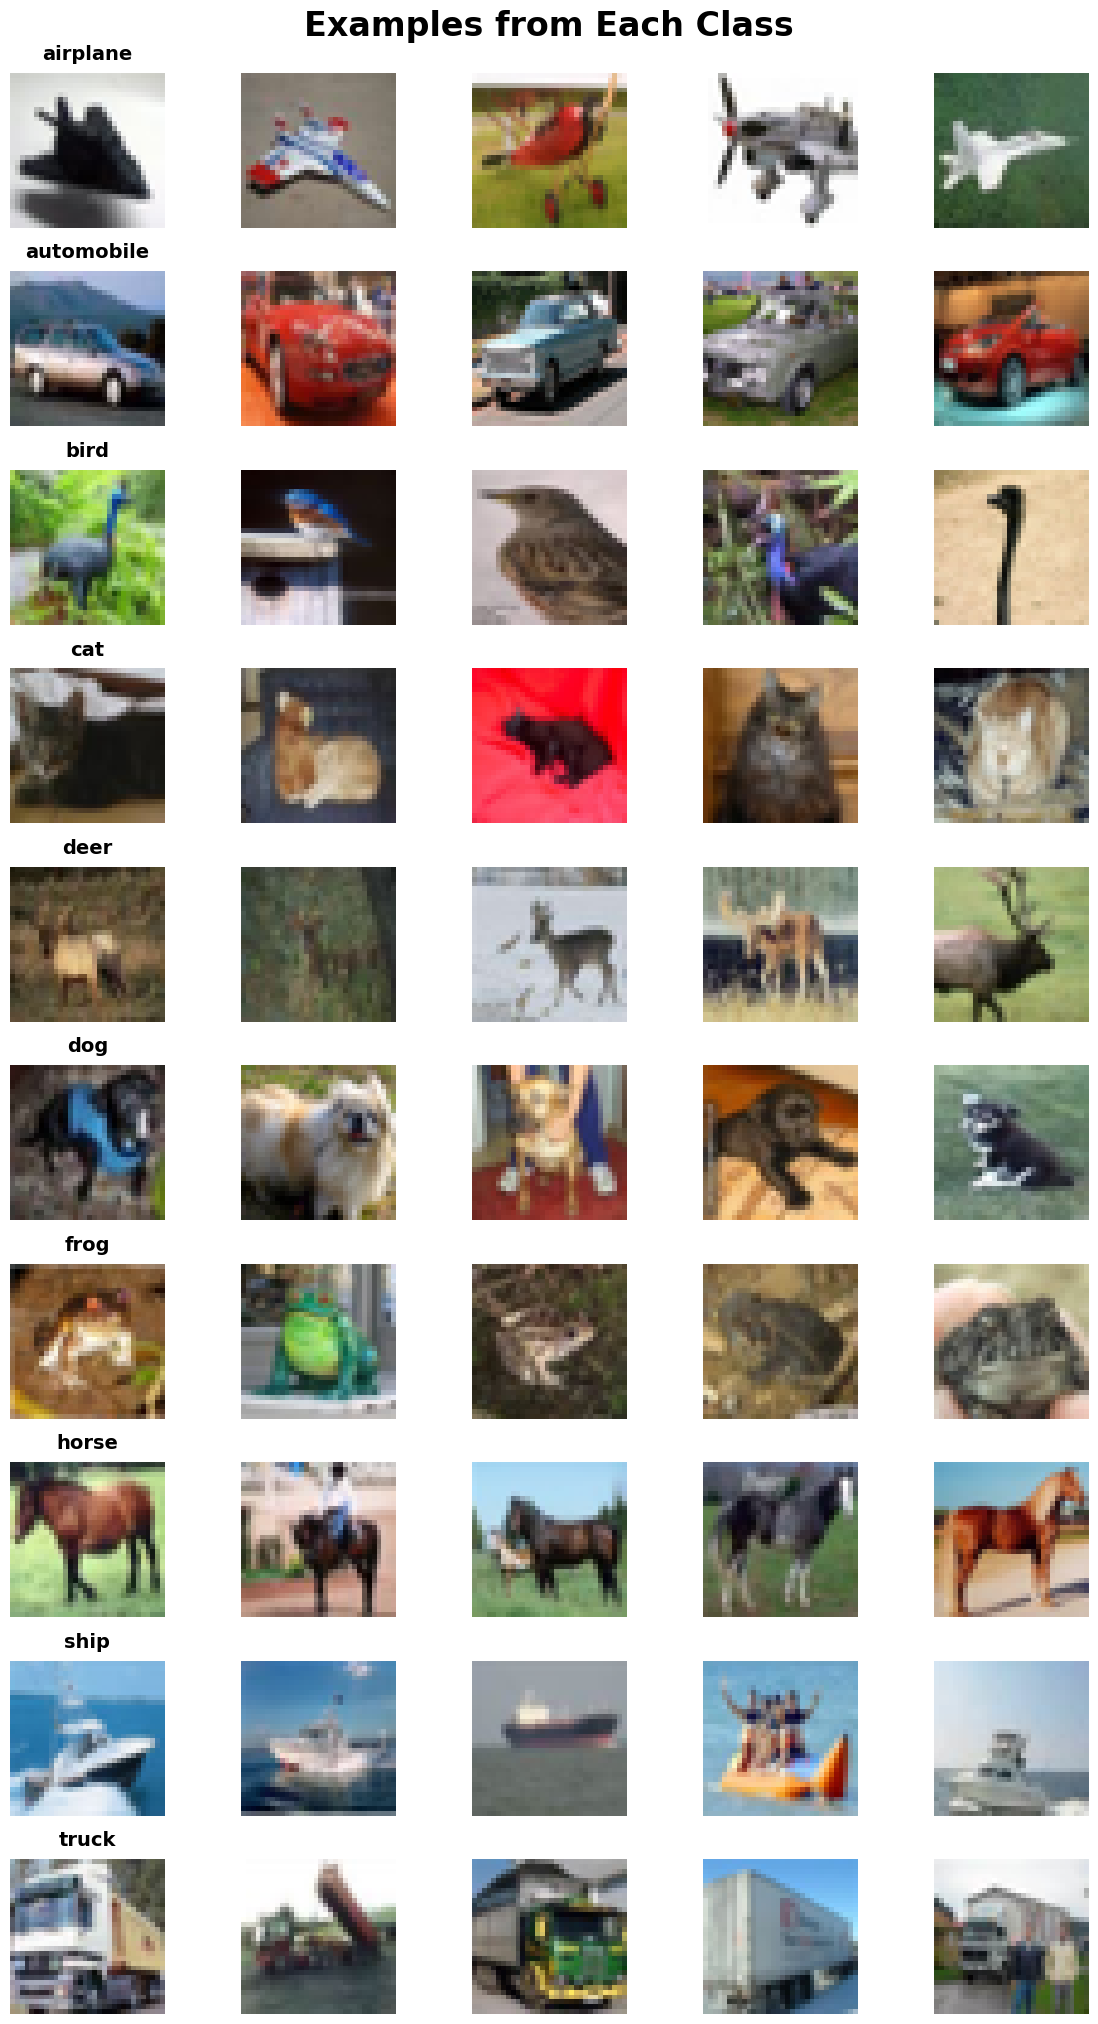


Class distribution in the training set:
   airplane    : 5000 images
   automobile  : 5000 images
   bird        : 5000 images
   cat         : 5000 images
   deer        : 5000 images
   dog         : 5000 images
   frog        : 5000 images
   horse       : 5000 images
   ship        : 5000 images
   truck       : 5000 images


In [4]:
def show_sample_images(X, y, class_names, n_per_class=5):

    """
    Displays examples for each class
    parameters: X: images, y: labels, class_names: list of class names

    """

    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_per_class, figsize=(12, 20))

    for i in range(n_classes):
        # Find n_per_class images from class i
        indices = np.where(y == i)[0][:n_per_class]

        for j, idx in enumerate(indices):
            axes[i, j].imshow(X[idx])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(class_names[i], fontsize=14, fontweight='bold', pad=10)

    plt.tight_layout()
    plt.suptitle('Examples from Each Class', fontsize=24, fontweight='bold', x=0.5, y=1.01)
    plt.savefig(f"{save_path}/sample_images.svg")
    plt.show()

print("\n" + "="*60)
print("DATA EXPLORING")
print("="*60)

show_sample_images(X_train, y_train, class_names, n_per_class=5)

# Κατανομή κλάσεων
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in the training set:")
for cls, count in zip(unique, counts):
    print(f"   {class_names[cls]:12s}: {count} images")

# **Προεπεξεργασία Δεδομένων**

In [5]:
def preprocess_data(X_train, X_test):

    """
    Converts images to vectors and normalizes
    parameters: X_train (train data), X_test (test data)
    returns: X_train_flat (normalized train data), X_test_flat (normalized test data)
    """

    # Flatten: (N, 32, 32, 3) -> (N, 3072)
    X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
    X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

    # Normalization [0, 255] -> [0, 1]
    X_train_flat = X_train_flat / 255.0
    X_test_flat = X_test_flat / 255.0

    return X_train_flat, X_test_flat

print("\n" + "="*60)
print("PREPROCESS")
print("="*60)

X_train_flat, X_test_flat = preprocess_data(X_train, X_test)

print(f"Training shape: {X_train_flat.shape}")
print(f"Test shape: {X_test_flat.shape}")
print(f"Normalization: [{X_train_flat.min():.2f}, {X_train_flat.max():.2f}]")


PREPROCESS
Training shape: (50000, 3072)
Test shape: (10000, 3072)
Normalization: [0.00, 1.00]


# **Υλοποίηση Nearest Neighbor (1-NN και 3-NN)**

In [6]:
def euclidean_distance(x1, x2):

    """
    Computes the Euclidean distance between two vectors x1,x2
    """

    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance_batch(X_test_point, X_train):

    """
    Manhattan distance (L1 norm) - more resistant to outliers

    """
    return np.sum(np.abs(X_train - X_test_point), axis=1)

def cosine_distance_batch(X_test_point, X_train):

    """
    Cosine distance - measures angles instead of length
    """

    dot_product = np.dot(X_train, X_test_point)
    norm_test = np.linalg.norm(X_test_point)
    norm_train = np.linalg.norm(X_train, axis=1)
    cosine_sim = dot_product / (norm_train * norm_test + 1e-8)
    return 1 - cosine_sim

def knn_classifier(X_train, y_train, X_test, k=1, distance_type='euclidean'):
    """
    K-Nearest Neighbors Classifier

    parameters: X_train: Training data (N_train, D)
                y_train: Training labels (N_train,)
                X_test: Test data (N_test, D)
                k: number of neighbors (default=1)
                distance_type: 'euclidean', 'manhattan', ή 'cosine' (default='euclidean')

    returns: predictions: Προβλέψεις για το test set (N_test,)
    """

    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    predictions = np.zeros(n_test, dtype=int)

    print(f"\nExcecution {k}-NN classifier ({distance_type} distance)...")
    print(f"Training samples: {n_train}")
    print(f"Test samples: {n_test}")

    start_time = time.time()

    for i in range(n_test):
        # Show progress every 1000 samples
        if (i + 1) % 1000 == 0:
            elapsed = time.time() - start_time
            print(f"   Processed {i+1}/{n_test} samples ({elapsed:.1f}s)")

        # Distance function choice
        if distance_type == 'manhattan':
            distances = manhattan_distance_batch(X_test[i], X_train)
        elif distance_type == 'cosine':
            distances = cosine_distance_batch(X_test[i], X_train)
        else:  # euclidean (default)
            distances = np.sqrt(np.sum((X_train - X_test[i]) ** 2, axis=1))

        # Find k nearest
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]

        # Voting
        if k == 1:
            predictions[i] = k_nearest_labels[0]
        else:
            # Majority
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions[i] = most_common[0][0]

    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time:.2f} seconds")

    return predictions

# **Υλοποίηση Nearest Class Centroid (NCC)**

In [7]:
def ncc_classifier(X_train, y_train, X_test):

    """
    Nearest Class Centroid Classifier

    Calculates the center (average) of each class and categorizes
    based on the closest center
    parameters: X_train: training data (N_train, D)
                y_train: training labels (N_train,)
                X_test: test data (N_test, D)

    returns: predictions: predictions for the test set (N_test,)
    """
    n_classes = len(np.unique(y_train))
    n_features = X_train.shape[1]

    # Calculating class centers
    print("\n Calculating class centers...")
    centroids = np.zeros((n_classes, n_features))

    for c in range(n_classes):
        # Find all samples of class c
        class_samples = X_train[y_train == c]

        # Average Calculation
        centroids[c] = np.mean(class_samples, axis=0)
        print(f"Class {c} ({class_names[c]}): {class_samples.shape[0]} samples")

    # Classification of test samples
    print("\n Excecuting NCC classifier...")
    n_test = X_test.shape[0]
    predictions = np.zeros(n_test, dtype=int)

    start_time = time.time()

    for i in range(n_test):
        if (i + 1) % 1000 == 0:
            elapsed = time.time() - start_time
            print(f"Processed {i+1}/{n_test} samples ({elapsed:.1f}s)")

        # Υπολογισμός απόστασης από όλα τα κέντρα
        distances = np.sqrt(np.sum((centroids - X_test[i]) ** 2, axis=1))

        # Πλησιέστερο κέντρο
        predictions[i] = np.argmin(distances)

    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time:.2f} seconds")

    return predictions

# **Αξιολόγηση και Σύγκριση**

In [13]:
def evaluate_classifier(y_true, y_pred, classifier_name):

    """
    Calculates performance metrics
    parameters: y_true: true labels (N,)
                y_pred: predicted labels (N,)
                classifier_name: name of the classifier
    returns: accuracy: accuracy of the classifier
    """

    accuracy = np.mean(y_true == y_pred) * 100

    print(f"\n{'='*60}")
    print(f"RESULTS: {classifier_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct Predictions: {np.sum(y_true == y_pred)}/{len(y_true)}")

    # Per-class accuracy
    print(f"\n Accuracy per class:")
    for c in range(len(class_names)):
        mask = y_true == c
        if np.sum(mask) > 0:
            class_acc = np.mean(y_pred[mask] == y_true[mask]) * 100
            print(f"   {class_names[c]:12s}: {class_acc:.2f}%")

    return accuracy

def save_confusion_matrix(y_true, y_pred, class_names, title, filename):

  """
  Saves confusion matrix
  parameters: y_true: true labels (N,)
              y_pred: predicted labels (N,)
              class_names: list of class names
              title: title of the confusion matrix
              filename: name of the file to save
  """

  n_classes = len(class_names)
  cm = np.zeros((n_classes, n_classes), dtype=int)

  for true_label, pred_label in zip(y_true, y_pred):
      cm[true_label, pred_label] += 1

  full_path = f"{save_path}/{filename}"

  plt.figure(figsize=(10, 8))
  plt.imshow(cm, interpolation='nearest', cmap='Blues')
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(n_classes)
  plt.xticks(tick_marks, class_names, rotation=45, ha='right')
  plt.yticks(tick_marks, class_names)

  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()
  plt.savefig(full_path, dpi=300, bbox_inches='tight')
  print(f"Saved: {filename}")
  plt.show()

def plot_detailed_confusion_matrix(y_true, y_pred, class_names, title, model_name,
                                   save_folder="confusion_matrices"):

    """
    Draws and saves a detailed confusion matrix (with percentages) directly to Google Drive.

    Parameters:
        y_true (array): True labels (N,)
        y_pred (array): Predicted labels (N,)
        class_names (list): List of class names
        title (str): Plot title
        model_name (str): Short name of the model (used in filename)
        save_folder (str): Drive folder name (default: 'confusion_matrices')
    """

    # Compute confusion matrix
    n_classes = len(class_names)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1

    # Convert to percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm_percent, cmap='RdYlGn', vmin=0, vmax=100)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Accuracy (%)', rotation=270, labelpad=20)

    # Axes labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Text inside cells
    for i in range(n_classes):
        for j in range(n_classes):
            text_color = 'white' if cm_percent[i, j] < 50 else 'black'
            ax.text(j, i, f'{cm_percent[i, j]:.1f}%\n({cm[i, j]})',
                    ha='center', va='center', color=text_color, fontsize=8)

    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save to Drive
    filename = f"cm_detailed_{model_name}.svg"
    full_path = f"{save_path}/{filename}"
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Saved to Google Drive: {full_path}")

    # Top-5 confusions
    print("\nTop-5 Most Frequent Confusions:")
    confusions = []
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j:
                confusions.append((class_names[i], class_names[j], cm[i, j]))

    confusions.sort(key=lambda x: x[2], reverse=True)
    for true_c, pred_c, count in confusions[:5]:
        print(f"   {true_c:10s} → {pred_c:10s}: {count} times")


# **Εκτέλεση όλων των Classifiers**

In [9]:
print("\n" + "="*60)
print("START CLASSIFICATION")
print("="*60)
print("WARNING: This may take several minutes...") # You can reduce the test set for faster results

# For FAST testing, use a smaller subset
USE_SUBSET = False
SUBSET_SIZE = 10000  # Αριθμός test samples

if USE_SUBSET:
    print(f"\n Using subset {SUBSET_SIZE} test samples for faster results")
    X_test_eval = X_test_flat[:SUBSET_SIZE]
    y_test_eval = y_test[:SUBSET_SIZE]
else:
    X_test_eval = X_test_flat
    y_test_eval = y_test

results = {}

print("\n" + "🔹"*30)
print("BASELINE CLASSIFIERS (Euclidean Distance)")
print("🔹"*30)

# 1-NN Classifier
pred_1nn = knn_classifier(X_train_flat, y_train, X_test_eval, k=1, distance_type='euclidean')
results['1-NN (Euclidean)'] = evaluate_classifier(y_test_eval, pred_1nn, "1-Nearest Neighbor (Euclidean)")

# 3-NN Classifier
pred_3nn = knn_classifier(X_train_flat, y_train, X_test_eval, k=3, distance_type='euclidean')
results['3-NN (Euclidean)'] = evaluate_classifier(y_test_eval, pred_3nn, "3-Nearest Neighbor (Euclidean)")

# NCC Classifier
pred_ncc = ncc_classifier(X_train_flat, y_train, X_test_eval)
results['NCC'] = evaluate_classifier(y_test_eval, pred_ncc, "Nearest Class Centroid")


# EXPERIMENT 1: DISTANCE METRICS (1-NN)
print("\n" + "🔹"*30)
print("EXPERIMENT: DISTANCE METRICS")
print("🔹"*30)
print("Comparison of different distance metrics with 1-NN")

# Manhattan Distance
pred_1nn_manhattan = knn_classifier(X_train_flat, y_train, X_test_eval, k=1, distance_type='manhattan')
results['1-NN (Manhattan)'] = evaluate_classifier(y_test_eval, pred_1nn_manhattan, "1-NN with Manhattan Distance")

# Cosine Distance
pred_1nn_cosine = knn_classifier(X_train_flat, y_train, X_test_eval, k=1, distance_type='cosine')
results['1-NN (Cosine)'] = evaluate_classifier(y_test_eval, pred_1nn_cosine, "1-NN with Cosine Distance")


# EXPERIMENT 2: DISTANCE METRICS (3-NN)
print("\n" + "🔹"*30)
print("EXPERIMENT: DISTANCE METRICS")
print("🔹"*30)
print("Comparison of different distance metrics with 3-NN")

# Manhattan Distance
pred_3nn_manhattan = knn_classifier(X_train_flat, y_train, X_test_eval, k=3, distance_type='manhattan')
results['3-NN (Manhattan)'] = evaluate_classifier(y_test_eval, pred_1nn_manhattan, "3-NN with Manhattan Distance")

# Cosine Distance
pred_3nn_cosine = knn_classifier(X_train_flat, y_train, X_test_eval, k=3, distance_type='cosine')
results['3-NN (Cosine)'] = evaluate_classifier(y_test_eval, pred_3nn_cosine, "3-NN with Cosine Distance")


# EXPERIMENT 3: PCA ANALYSIS
print("\n" + "🔹"*30)
print("EXPERIMENT: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("🔹"*30)
print("Dimension reduction for faster processing")

# We try a few basic settings
pca_configs = [50, 100, 200]
pca_results = {}

for n_components in pca_configs:
    print(f"\n{'─'*60}")
    print(f"Testing PCA with {n_components} components")
    print(f"{'─'*60}")

    # Implementation PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_eval)

    explained_var = pca.explained_variance_ratio_.sum() * 100
    print(f"Explained variance: {explained_var:.2f}%")
    print(f"Dimensions: {X_train_flat.shape[1]} → {n_components}")

    # Test with NCC
    pred_pca = ncc_classifier(X_train_pca, y_train, X_test_pca)
    acc = evaluate_classifier(y_test_eval, pred_pca, f"CNN with PCA-{n_components}")

    pca_results[f'CNN (PCA-{n_components})'] = {
        'accuracy': acc,
        'explained_var': explained_var,
        'n_components': n_components
    }
    results[f'CNN (PCA-{n_components})'] = acc


START CLASSIFICATION

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
BASELINE CLASSIFIERS (Euclidean Distance)
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

Excecution 1-NN classifier (euclidean distance)...
Training samples: 50000
Test samples: 10000
   Processed 1000/10000 samples (398.2s)
   Processed 2000/10000 samples (790.4s)
   Processed 3000/10000 samples (1181.5s)
   Processed 4000/10000 samples (1570.9s)
   Processed 5000/10000 samples (1966.3s)
   Processed 6000/10000 samples (2364.3s)
   Processed 7000/10000 samples (2760.7s)
   Processed 8000/10000 samples (3154.5s)
   Processed 9000/10000 samples (3569.8s)
   Processed 10000/10000 samples (3968.2s)
Completed in 3968.58 seconds

RESULTS: 1-Nearest Neighbor (Euclidean)
Accuracy: 35.39%
Correct Predictions: 3539/10000

 Accuracy per class:
   airplane    : 48.50%
   automobile  : 21.80%
   bird        : 38.40%
   cat         : 24.00%
   deer        : 45.70%
   dog         : 29.00%
   frog        : 35.30%
   horse       : 29.40%
   ship        : 61.90%
 

# **Συγκριτικά Αποτελέσματα**

In [27]:
# COMPARATIVE ANALYSIS - VISUALIZATION

print("\n" + "="*60)
print("COMPARATIVE ANALYSIS")
print("="*60)

# RESULTS COLLECTION

results = {}
all_predictions = {}


COMPARATIVE ANALYSIS


## **Baseline Classifiers**


In [28]:
# Baseline Classifiers
print("\n" + "🔹"*30)
print("BASELINE CLASSIFIERS (Euclidean Distance)")
print("🔹"*30)

# 1-NN
results['1-NN (Euclidean)'] = evaluate_classifier(y_test_eval, pred_1nn, "1-Nearest Neighbor (Euclidean)")
all_predictions['1-NN'] = pred_1nn

# 3-NN
results['3-NN (Euclidean)'] = evaluate_classifier(y_test_eval, pred_3nn, "3-Nearest Neighbor (Euclidean)")
all_predictions['3-NN'] = pred_3nn

# NCC
results['NCC'] = evaluate_classifier(y_test_eval, pred_ncc, "Nearest Class Centroid")
all_predictions['NCC'] = pred_ncc


🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
BASELINE CLASSIFIERS (Euclidean Distance)
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

RESULTS: 1-Nearest Neighbor (Euclidean)
Accuracy: 35.39%
Correct Predictions: 3539/10000

 Accuracy per class:
   airplane    : 48.50%
   automobile  : 21.80%
   bird        : 38.40%
   cat         : 24.00%
   deer        : 45.70%
   dog         : 29.00%
   frog        : 35.30%
   horse       : 29.40%
   ship        : 61.90%
   truck       : 19.90%

RESULTS: 3-Nearest Neighbor (Euclidean)
Accuracy: 35.61%
Correct Predictions: 3561/10000

 Accuracy per class:
   airplane    : 49.20%
   automobile  : 21.50%
   bird        : 39.00%
   cat         : 21.80%
   deer        : 48.60%
   dog         : 29.30%
   frog        : 33.90%
   horse       : 28.30%
   ship        : 65.20%
   truck       : 19.30%

RESULTS: Nearest Class Centroid
Accuracy: 27.74%
Correct Predictions: 2774/10000

 Accuracy per class:
   airplane    : 53.90%
   automobile  : 18.60%
   bird        : 10.70%
   cat         

## **Distance Metrics**

In [29]:
# Distance Metrics Experiments
print("\n" + "🔹"*30)
print("EXPERIMENT: DISTANCE METRICS")
print("🔹"*30)

# Manhattan
results['3-NN (Manhattan)'] = evaluate_classifier(y_test_eval, pred_3nn_manhattan, "3-NN with Manhattan Distance")
all_predictions['3-NN-Manhattan'] = pred_3nn_manhattan

# Cosine
results['3-NN (Cosine)'] = evaluate_classifier(y_test_eval, pred_3nn_cosine, "3-NN with Cosine Distance")
all_predictions['3-NN-Cosine'] = pred_3nn_cosine


🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
EXPERIMENT: DISTANCE METRICS
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

RESULTS: 3-NN with Manhattan Distance
Accuracy: 39.22%
Correct Predictions: 3922/10000

 Accuracy per class:
   airplane    : 53.00%
   automobile  : 28.80%
   bird        : 40.10%
   cat         : 24.80%
   deer        : 48.00%
   dog         : 31.60%
   frog        : 35.90%
   horse       : 34.70%
   ship        : 67.50%
   truck       : 27.80%

RESULTS: 3-NN with Cosine Distance
Accuracy: 37.74%
Correct Predictions: 3774/10000

 Accuracy per class:
   airplane    : 52.50%
   automobile  : 26.50%
   bird        : 37.10%
   cat         : 24.30%
   deer        : 43.40%
   dog         : 32.30%
   frog        : 32.00%
   horse       : 33.40%
   ship        : 71.30%
   truck       : 24.60%


## **PCA Experiments**

In [30]:
# PCA Experiments
print("\n" + "🔹"*30)
print("ΠΕΙΡΑΜΑ: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("🔹"*30)

pca_configs = [50, 100, 200]
pca_results = {}

for n_components in pca_configs:
    print(f"\n{'─'*60}")
    print(f"Testing PCA with {n_components} components")
    print(f"{'─'*60}")

    # Test with 3-NN
    acc = evaluate_classifier(y_test_eval, pred_pca, f"3-NN with PCA-{n_components}")

    pca_results[f'3-NN (PCA-{n_components})'] = {
        'accuracy': acc,
        'explained_var': explained_var,
        'n_components': n_components
    }
    results[f'3-NN (PCA-{n_components})'] = acc
    all_predictions[f'3-NN-PCA-{n_components}'] = pred_pca


🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
ΠΕΙΡΑΜΑ: PRINCIPAL COMPONENT ANALYSIS (PCA)
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

────────────────────────────────────────────────────────────
Testing PCA with 50 components
────────────────────────────────────────────────────────────

RESULTS: 3-NN with PCA-50
Accuracy: 27.74%
Correct Predictions: 2774/10000

 Accuracy per class:
   airplane    : 53.90%
   automobile  : 18.60%
   bird        : 10.70%
   cat         : 5.70%
   deer        : 11.80%
   dog         : 28.70%
   frog        : 53.90%
   horse       : 16.60%
   ship        : 36.90%
   truck       : 40.60%

────────────────────────────────────────────────────────────
Testing PCA with 100 components
────────────────────────────────────────────────────────────

RESULTS: 3-NN with PCA-100
Accuracy: 27.74%
Correct Predictions: 2774/10000

 Accuracy per class:
   airplane    : 53.90%
   automobile  : 18.60%
   bird        : 10.70%
   cat         : 5.70%
   deer        : 11.80%
   dog         : 28.70%
   fr

## **Confusion Matrixes**


GENERATING CONFUSION MATRICES
Saved: cm_1nn.png


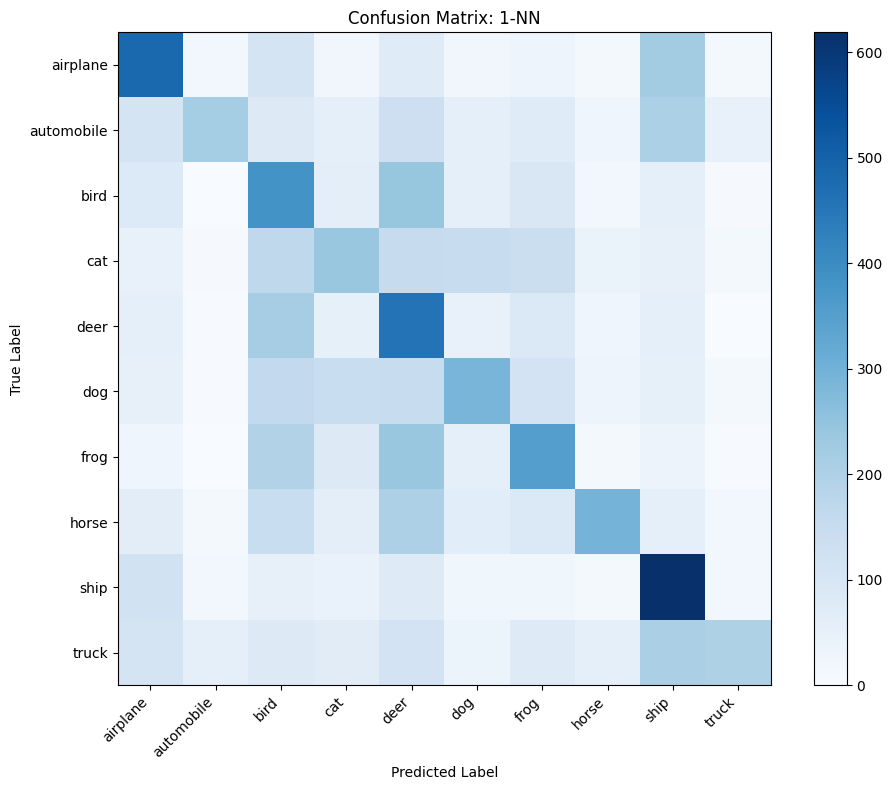

Saved: cm_3nn.png


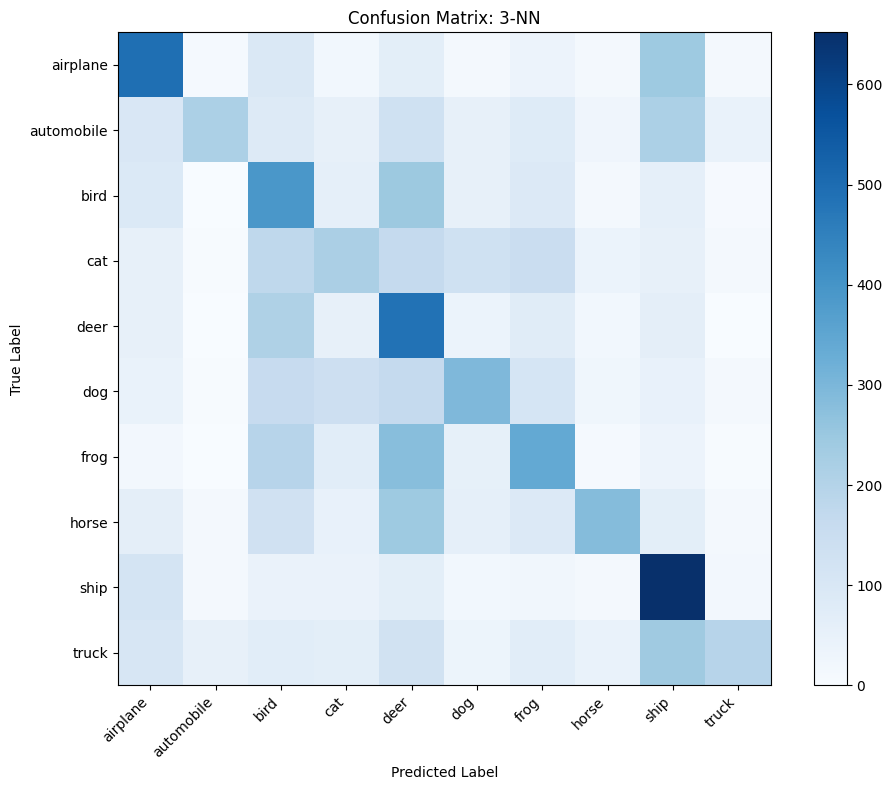

Saved: cm_ncc.png


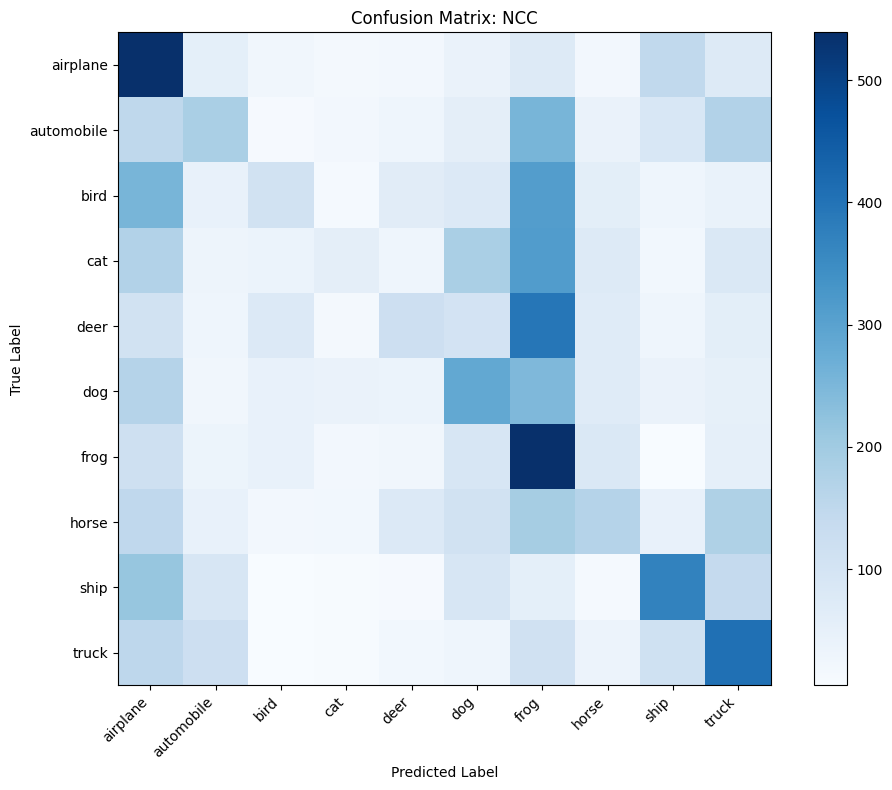


Generating detailed confusion matrices...


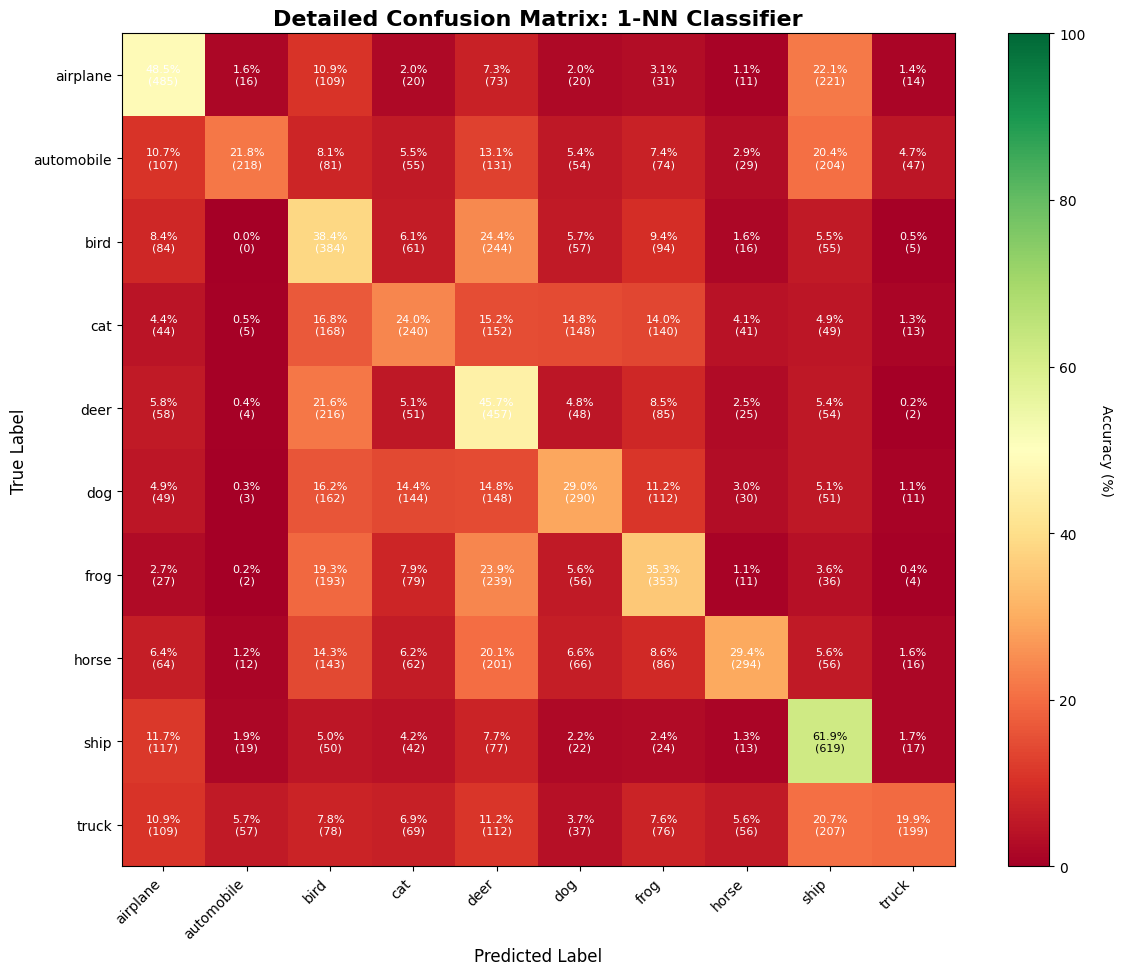

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_1nn.svg

Top-5 Most Frequent Confusions:
   bird       → deer      : 244 times
   frog       → deer      : 239 times
   airplane   → ship      : 221 times
   deer       → bird      : 216 times
   truck      → ship      : 207 times


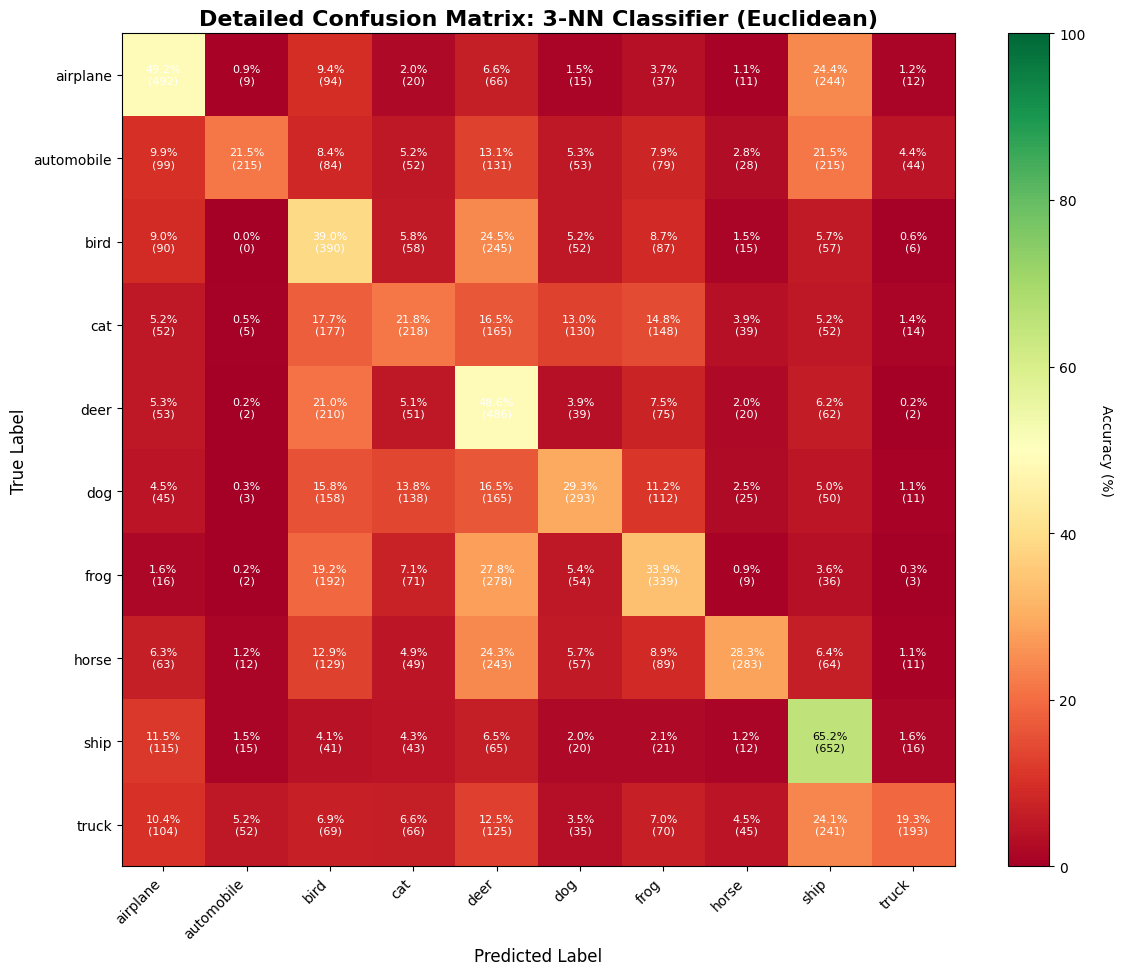

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_3nn_euclidean.svg

Top-5 Most Frequent Confusions:
   frog       → deer      : 278 times
   bird       → deer      : 245 times
   airplane   → ship      : 244 times
   horse      → deer      : 243 times
   truck      → ship      : 241 times


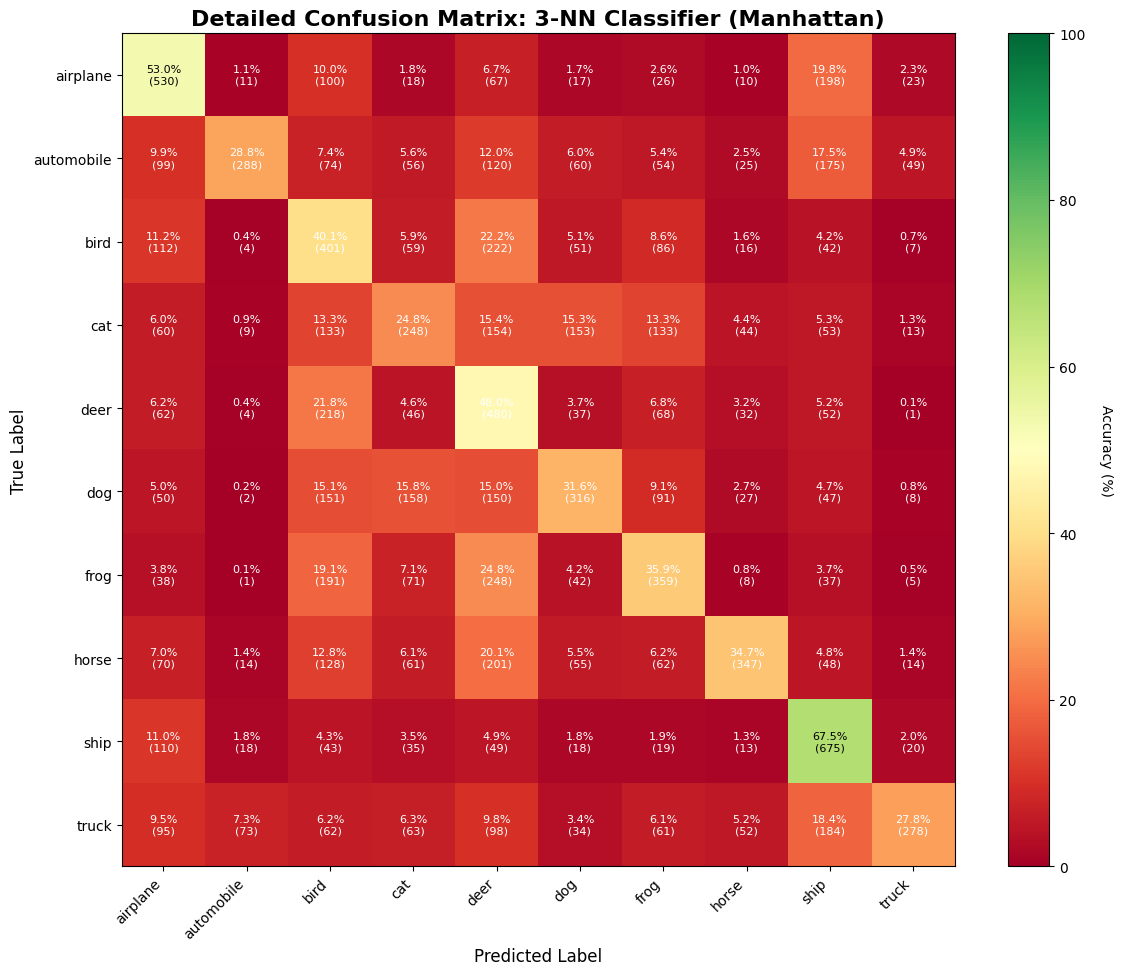

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_3nn_manhattan.svg

Top-5 Most Frequent Confusions:
   frog       → deer      : 248 times
   bird       → deer      : 222 times
   deer       → bird      : 218 times
   horse      → deer      : 201 times
   airplane   → ship      : 198 times


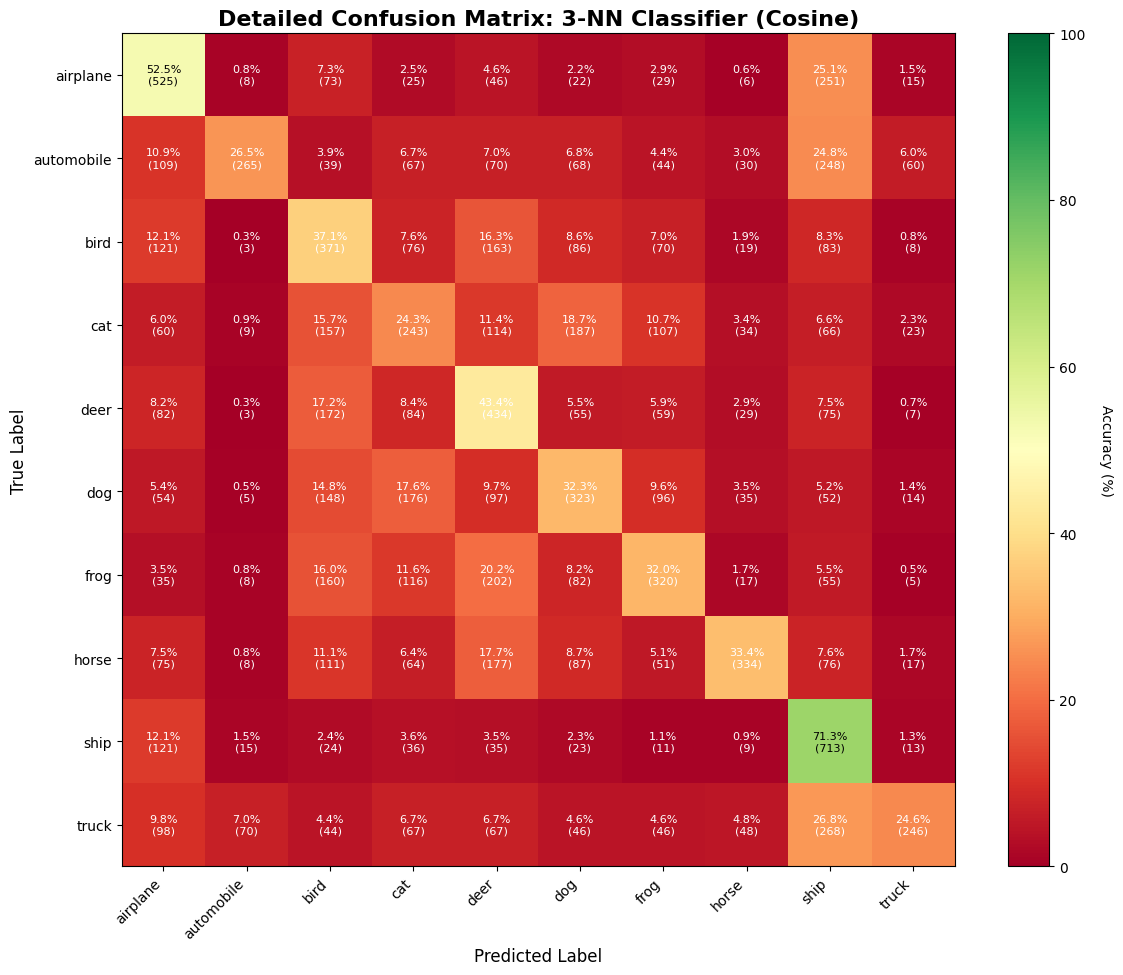

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_3nn_cosine.svg

Top-5 Most Frequent Confusions:
   truck      → ship      : 268 times
   airplane   → ship      : 251 times
   automobile → ship      : 248 times
   frog       → deer      : 202 times
   cat        → dog       : 187 times


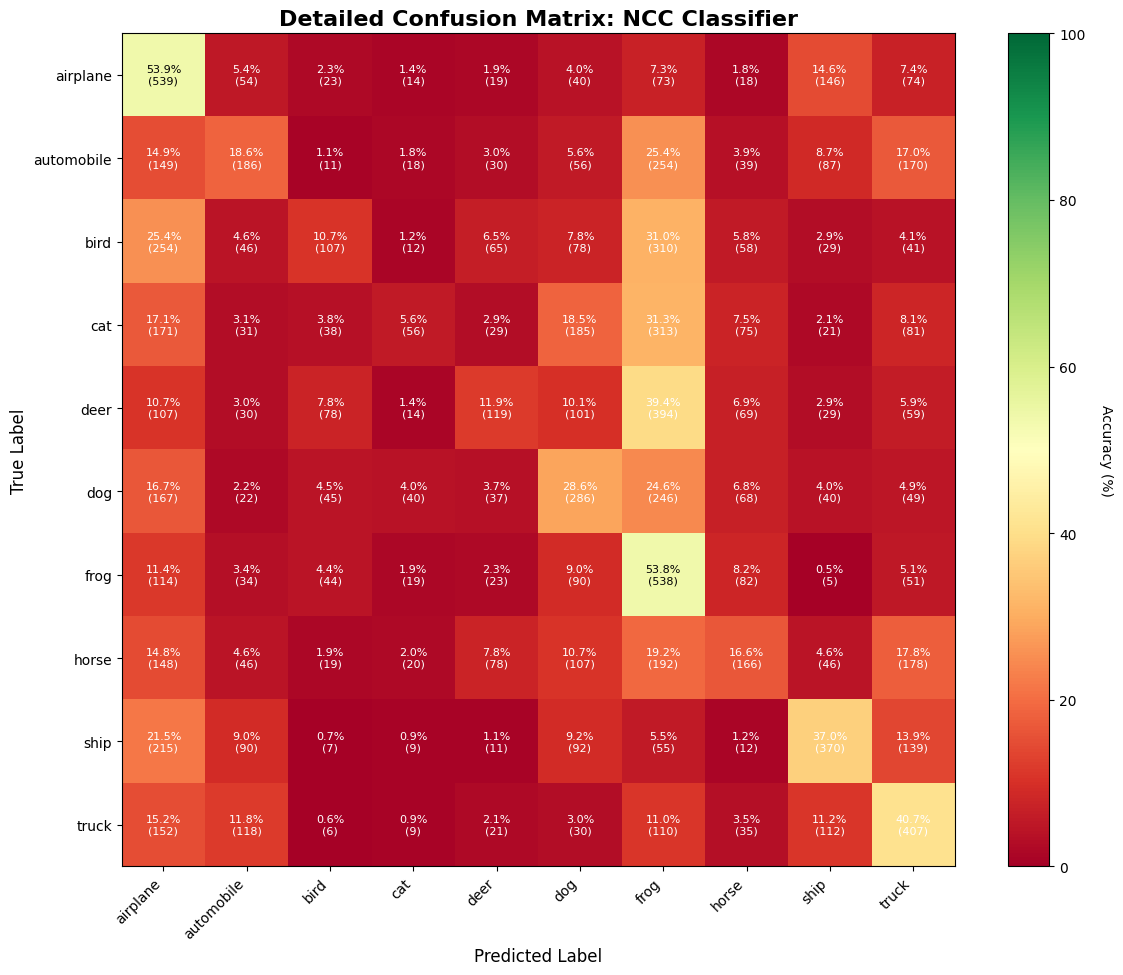

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_ncc.svg

Top-5 Most Frequent Confusions:
   deer       → frog      : 394 times
   cat        → frog      : 313 times
   bird       → frog      : 310 times
   automobile → frog      : 254 times
   bird       → airplane  : 254 times


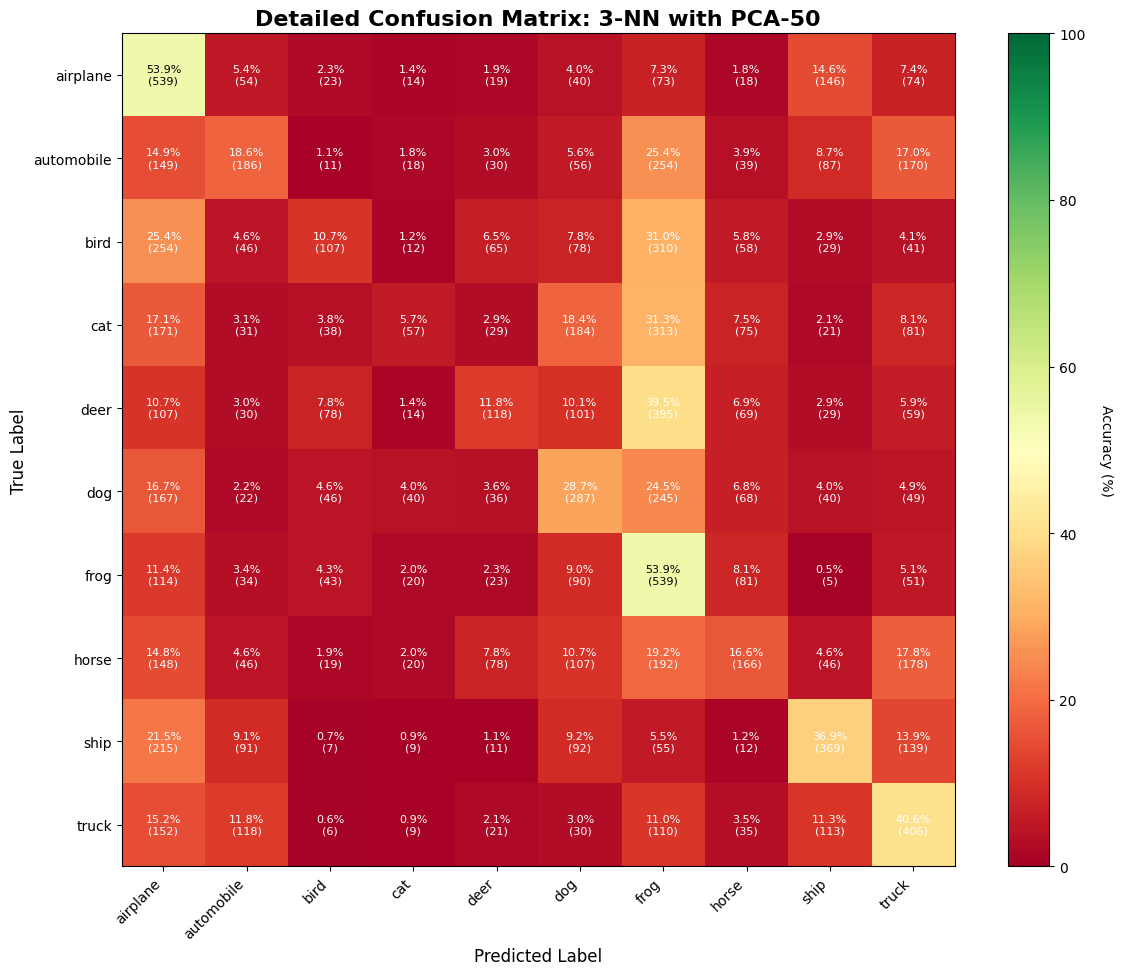

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/cm_detailed_3nn_pca50.svg

Top-5 Most Frequent Confusions:
   deer       → frog      : 395 times
   cat        → frog      : 313 times
   bird       → frog      : 310 times
   automobile → frog      : 254 times
   bird       → airplane  : 254 times


In [31]:
# CONFUSION MATRICES

print("\n" + "="*60)
print("GENERATING CONFUSION MATRICES")
print("="*60)

# Baseline confusion matrices (simple)
save_confusion_matrix(y_test_eval, pred_1nn, class_names,
                     "Confusion Matrix: 1-NN", "cm_1nn.png")

save_confusion_matrix(y_test_eval, pred_3nn, class_names,
                     "Confusion Matrix: 3-NN", "cm_3nn.png")

save_confusion_matrix(y_test_eval, pred_ncc, class_names,
                     "Confusion Matrix: NCC", "cm_ncc.png")

# Detailed confusion matrices (with percentages)
print("\nGenerating detailed confusion matrices...")

plot_detailed_confusion_matrix(y_test_eval, pred_1nn, class_names,
                              "Detailed Confusion Matrix: 1-NN Classifier",
                              "1nn")

plot_detailed_confusion_matrix(y_test_eval, pred_3nn, class_names,
                              "Detailed Confusion Matrix: 3-NN Classifier (Euclidean)",
                              "3nn_euclidean")

plot_detailed_confusion_matrix(y_test_eval, pred_3nn_manhattan, class_names,
                              "Detailed Confusion Matrix: 3-NN Classifier (Manhattan)",
                              "3nn_manhattan")

plot_detailed_confusion_matrix(y_test_eval, pred_3nn_cosine, class_names,
                              "Detailed Confusion Matrix: 3-NN Classifier (Cosine)",
                              "3nn_cosine")

plot_detailed_confusion_matrix(y_test_eval, pred_ncc, class_names,
                              "Detailed Confusion Matrix: NCC Classifier",
                              "ncc")

# PCA confusion matrices (only the best)
best_pca_key = max(pca_results, key=lambda k: pca_results[k]['accuracy'])
best_pca_pred = all_predictions[best_pca_key.replace(' ', '-').replace('(', '').replace(')', '')]
best_pca_n = pca_results[best_pca_key]['n_components']

plot_detailed_confusion_matrix(y_test_eval, best_pca_pred, class_names,
                              f"Detailed Confusion Matrix: 3-NN with PCA-{best_pca_n}",
                              f"3nn_pca{best_pca_n}")

## **Custom Plots**

In [32]:
print("\n" + "="*60)
print("GENERATING COMPARISON PLOTS")
print("="*60)

# Prepare categories
baseline_methods = ['1-NN (Euclidean)', '3-NN (Euclidean)', 'NCC']
distance_methods = ['3-NN (Manhattan)', '3-NN (Cosine)']
pca_methods = [k for k in results.keys() if 'PCA' in k]


GENERATING COMPARISON PLOTS


### **PLOT 1: BASELINE COMPARISON**


Creating Plot 1: Baseline Classifiers...
Saved: baseline_comparison.svg


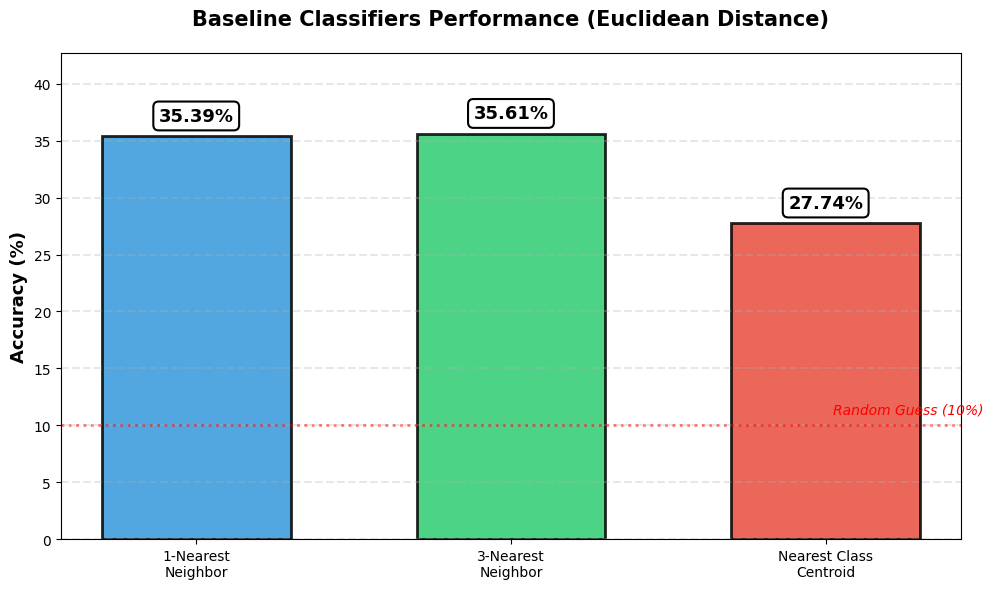

In [33]:
print("\nCreating Plot 1: Baseline Classifiers...")

fig, ax = plt.subplots(figsize=(10, 6))

baseline_names = ['1-Nearest\nNeighbor', '3-Nearest\nNeighbor', 'Nearest Class\nCentroid']
baseline_accs = [results[m] for m in baseline_methods]
baseline_colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(baseline_names, baseline_accs, color=baseline_colors,
              alpha=0.85, edgecolor='black', linewidth=2, width=0.6)

ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Baseline Classifiers Performance (Euclidean Distance)',
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim([0, max(baseline_accs) * 1.2])
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add values
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                     edgecolor='black', linewidth=1.5))

# Random guess line
ax.axhline(y=10, color='red', linestyle=':', alpha=0.5, linewidth=2)
ax.text(2.5, 11, 'Random Guess (10%)', ha='right', fontsize=10,
        style='italic', color='red')

plt.tight_layout()
full_path = f"{save_path}/baseline_comparison.svg"
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Saved: baseline_comparison.svg")
plt.show()

### **PLOT 2: DISTANCE METRICS COMPARISON**


Creating Plot 2: Distance Metrics Comparison...


/tmp/ipython-input-34548035.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved: distance_metrics_comparison.png


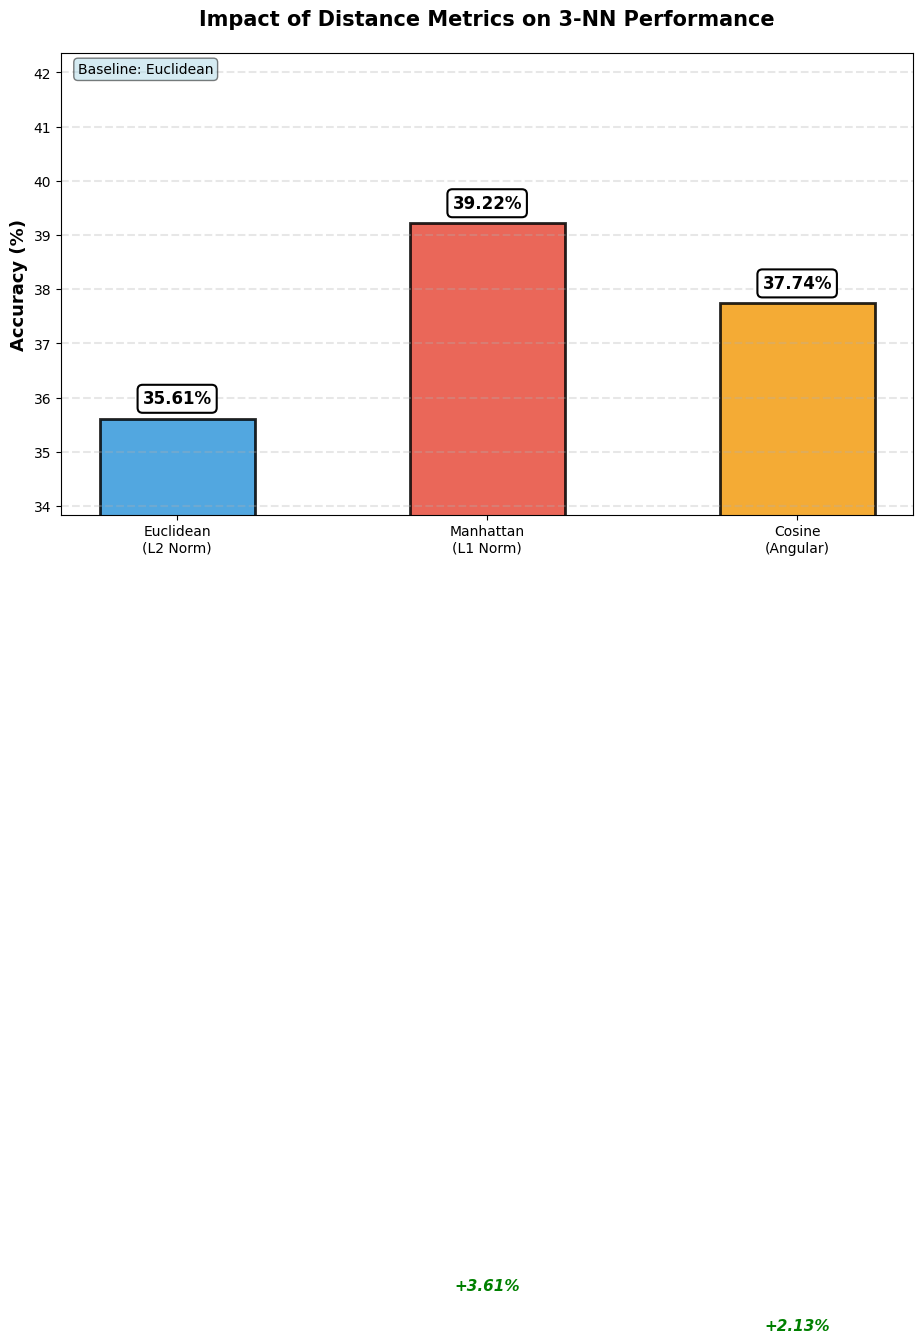

In [34]:
print("\nCreating Plot 2: Distance Metrics Comparison...")

fig, ax = plt.subplots(figsize=(11, 6))

distance_names = ['Euclidean\n(L2 Norm)', 'Manhattan\n(L1 Norm)', 'Cosine\n(Angular)']
distance_full_methods = ['3-NN (Euclidean)', '3-NN (Manhattan)', '3-NN (Cosine)']
distance_accs = [results[m] for m in distance_full_methods]
colors_dist = ['#3498db', '#e74c3c', '#f39c12']

bars = ax.bar(distance_names, distance_accs, color=colors_dist,
              alpha=0.85, edgecolor='black', linewidth=2, width=0.5)

ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Impact of Distance Metrics on 3-NN Performance',
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim([min(distance_accs) * 0.95, max(distance_accs) * 1.08])
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add values
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                     edgecolor='black', linewidth=1.5))

# Add difference from baseline
baseline_euclidean = distance_accs[0]
for i, (bar, acc) in enumerate(zip(bars[1:], distance_accs[1:]), 1):
    diff = acc - baseline_euclidean
    color = 'green' if diff > 0 else 'red'
    symbol = '+' if diff >= 0 else ''
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() * 0.5,
            f'{symbol}{diff:.2f}%',
            ha='center', va='center', fontsize=11, fontweight='bold',
            color=color, style='italic')

# Annotation
ax.text(0.02, 0.98, 'Baseline: Euclidean', transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
full_path = f"{save_path}/distance_metrics_comparison.svg"
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Saved: distance_metrics_comparison.png")
plt.show()

### **PLOT 3: PCA DETAILED ANALYSIS (4 subplots)**


Creating Plot 3: PCA Detailed Analysis...
Saved: pca_detailed_analysis.svg


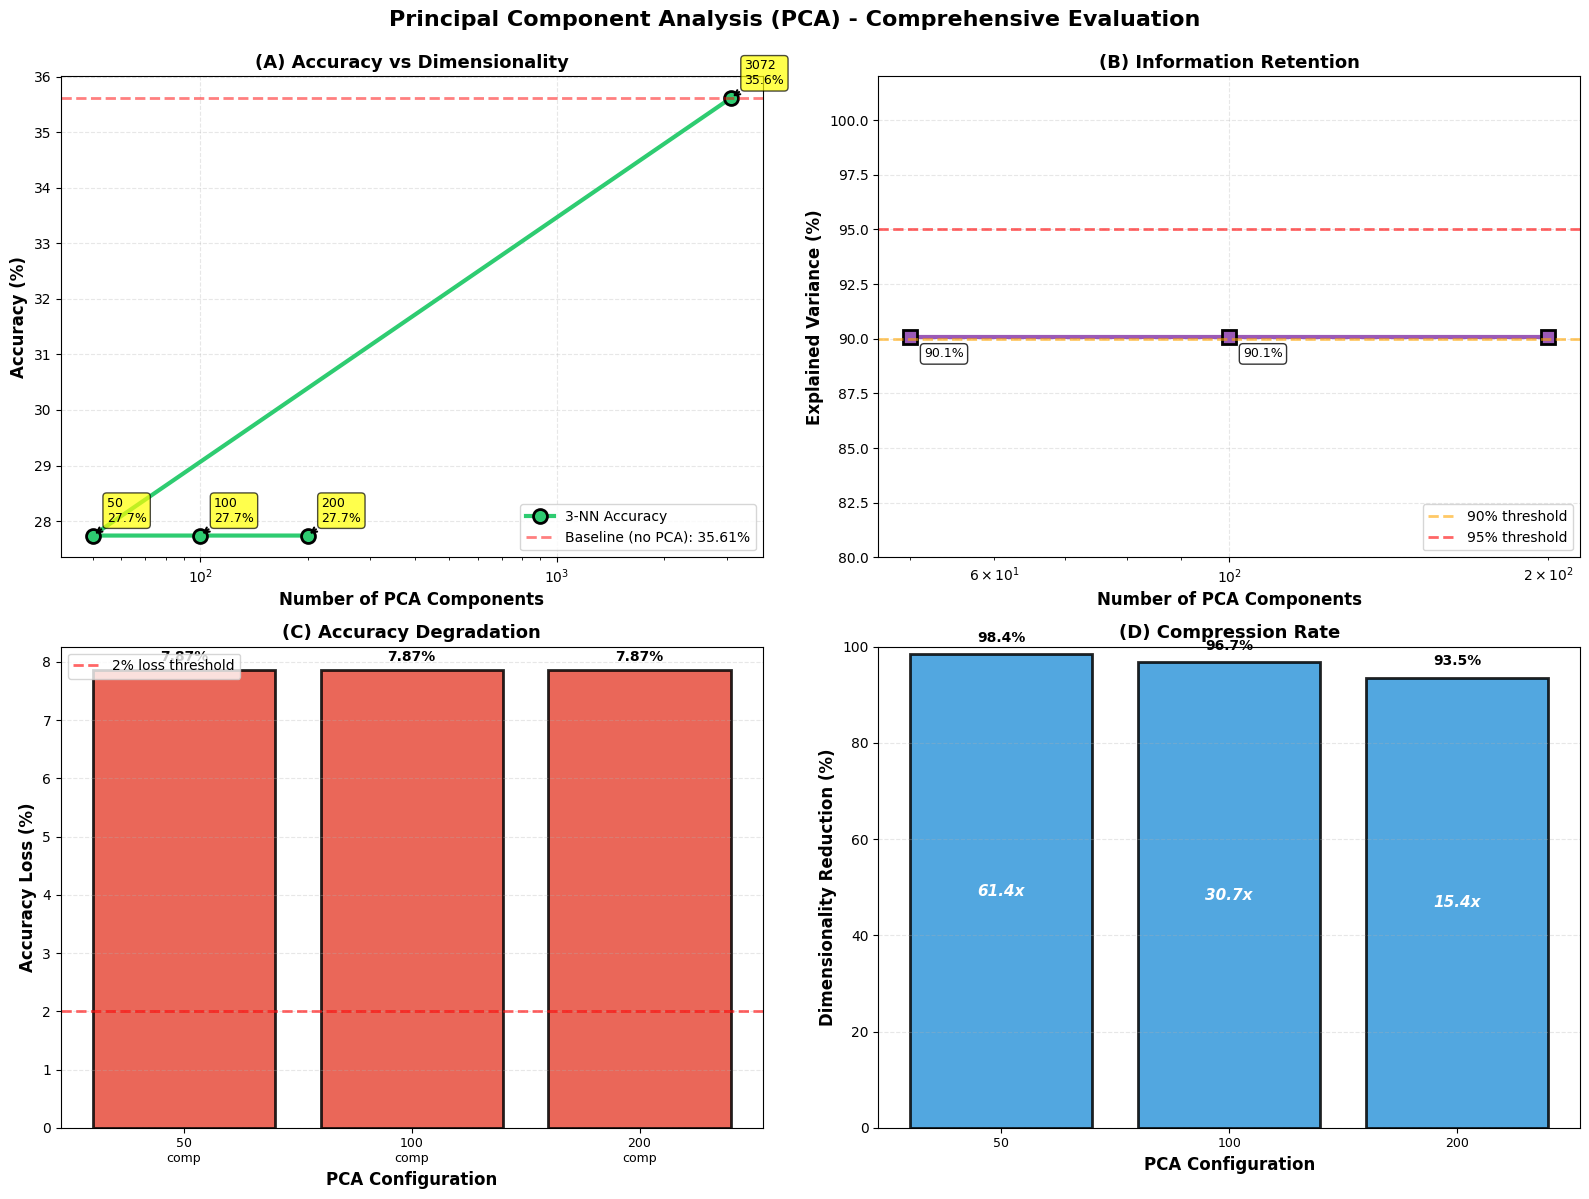

In [36]:
print("\nCreating Plot 3: PCA Detailed Analysis...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Prepare PCA data
pca_components = [pca_results[k]['n_components'] for k in pca_methods]
pca_accuracies = [pca_results[k]['accuracy'] for k in pca_methods]
pca_variances = [pca_results[k]['explained_var'] for k in pca_methods]
original_acc = results['3-NN (Euclidean)']

# Add original (no PCA)
pca_components_full = [3072] + pca_components
pca_accuracies_full = [original_acc] + pca_accuracies
pca_variances_full = [100.0] + pca_variances

# ─── Subplot 1: Accuracy vs Components ───
ax1.plot(pca_components_full, pca_accuracies_full, 'o-',
         linewidth=3, markersize=10, color='#2ecc71', markeredgecolor='black',
         markeredgewidth=2, label='3-NN Accuracy')
ax1.axhline(y=original_acc, color='red', linestyle='--', linewidth=2,
            alpha=0.5, label=f'Baseline (no PCA): {original_acc:.2f}%')

ax1.set_xlabel('Number of PCA Components', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('(A) Accuracy vs Dimensionality', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='lower right', fontsize=10)

# Annotate key points
for comp, acc in zip(pca_components_full, pca_accuracies_full):
    if comp in [50, 100, 200, 3072]:
        ax1.annotate(f'{comp}\n{acc:.1f}%',
                    xy=(comp, acc), xytext=(10, 10),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', lw=1.5))

# ─── Subplot 2: Explained Variance ───
ax2.plot(pca_components, pca_variances, 's-',
         linewidth=3, markersize=10, color='#9b59b6', markeredgecolor='black',
         markeredgewidth=2)
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2, alpha=0.6,
            label='90% threshold')
ax2.axhline(y=95, color='red', linestyle='--', linewidth=2, alpha=0.6,
            label='95% threshold')

ax2.set_xlabel('Number of PCA Components', fontsize=12, fontweight='bold')
ax2.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax2.set_title('(B) Information Retention', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.set_ylim([80, 102])
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='lower right', fontsize=10)

# Annotate
for comp, var in zip(pca_components, pca_variances):
    if comp in [50, 100]:
        ax2.annotate(f'{var:.1f}%',
                    xy=(comp, var), xytext=(10, -15),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ─── Subplot 3: Accuracy Loss ───
accuracy_losses = [original_acc - acc for acc in pca_accuracies]

bars = ax3.bar(range(len(pca_components)), accuracy_losses,
              color=['#e74c3c' if loss > 2 else '#2ecc71' for loss in accuracy_losses],
              alpha=0.85, edgecolor='black', linewidth=2)

ax3.axhline(y=2, color='red', linestyle='--', linewidth=2, alpha=0.6,
           label='2% loss threshold')
ax3.set_xlabel('PCA Configuration', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy Loss (%)', fontsize=12, fontweight='bold')
ax3.set_title('(C) Accuracy Degradation', fontsize=13, fontweight='bold')
ax3.set_xticks(range(len(pca_components)))
ax3.set_xticklabels([f'{c}\ncomp' for c in pca_components], fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.legend(loc='upper left', fontsize=10)

# Add values
for i, (bar, loss) in enumerate(zip(bars, accuracy_losses)):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
            f'{loss:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ─── Subplot 4: Dimensionality Reduction ───
dimension_reduction = [(3072 - c) / 3072 * 100 for c in pca_components]

bars = ax4.bar(range(len(pca_components)), dimension_reduction,
              color='#3498db', alpha=0.85, edgecolor='black', linewidth=2)

ax4.set_xlabel('PCA Configuration', fontsize=12, fontweight='bold')
ax4.set_ylabel('Dimensionality Reduction (%)', fontsize=12, fontweight='bold')
ax4.set_title('(D) Compression Rate', fontsize=13, fontweight='bold')
ax4.set_xticks(range(len(pca_components)))
ax4.set_xticklabels([f'{c}' for c in pca_components], fontsize=9)
ax4.set_ylim([0, 100])
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# Add values
for i, (bar, reduction) in enumerate(zip(bars, dimension_reduction)):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
            f'{reduction:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Compression ratio
    ratio = 3072 / pca_components[i]
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() / 2,
            f'{ratio:.1f}x',
            ha='center', va='center', fontsize=11, fontweight='bold',
            color='white', style='italic')

plt.suptitle('Principal Component Analysis (PCA) - Comprehensive Evaluation',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
full_path = f"{save_path}/pca_detailed_analysis.svg"
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Saved: pca_detailed_analysis.svg")
plt.show()

### **PLOT 4: COMPLETE COMPARISON (All methods)**


Creating Plot 4: Complete Methods Comparison...
Saved: complete_methods_comparison.svg


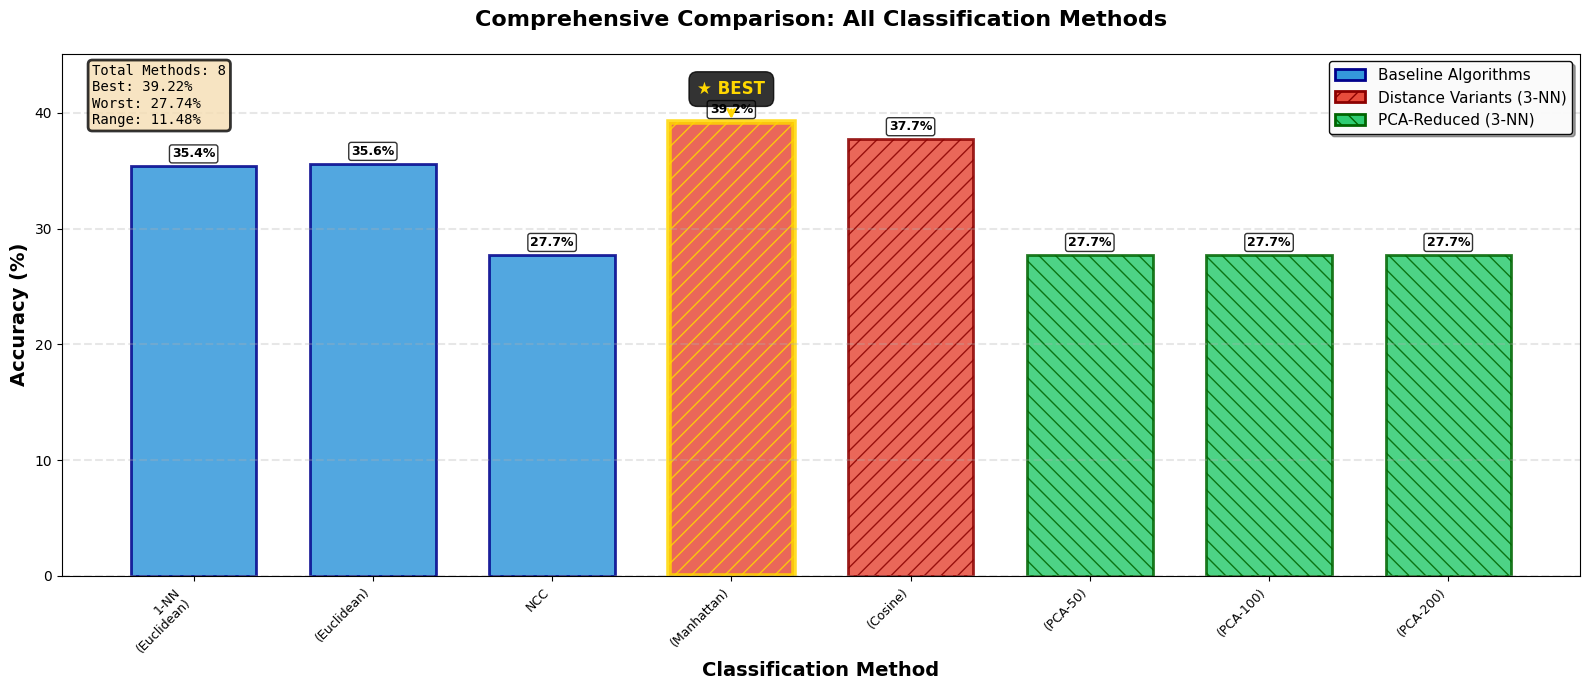

In [37]:
print("\nCreating Plot 4: Complete Methods Comparison...")

fig, ax = plt.subplots(figsize=(16, 7))

all_methods = baseline_methods + distance_methods + pca_methods
all_accuracies = [results[m] for m in all_methods]

# Colors and patterns
colors = []
edge_colors = []
hatches = []

for m in all_methods:
    if m in baseline_methods:
        colors.append('#3498db')
        edge_colors.append('darkblue')
        hatches.append('')
    elif m in distance_methods:
        colors.append('#e74c3c')
        edge_colors.append('darkred')
        hatches.append('//')
    else:  # PCA
        colors.append('#2ecc71')
        edge_colors.append('darkgreen')
        hatches.append('\\\\')

# Create bars
x_pos = np.arange(len(all_methods))
bars = ax.bar(x_pos, all_accuracies, color=colors,
              alpha=0.85, edgecolor=edge_colors, linewidth=2, width=0.7)

# Add patterns
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Classification Method', fontsize=14, fontweight='bold')
ax.set_title('Comprehensive Comparison: All Classification Methods',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels([m.replace('3-NN ', '').replace(' (', '\n(').replace(')', ')')
                     for m in all_methods],
                    rotation=45, ha='right', fontsize=9)
ax.set_ylim([0, max(all_accuracies) * 1.15])
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.5)

# Add values
for i, (bar, acc) in enumerate(zip(bars, all_accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Highlight best method
best_idx = all_accuracies.index(max(all_accuracies))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)
ax.annotate('★ BEST', xy=(best_idx, all_accuracies[best_idx]),
            xytext=(0, 20), textcoords='offset points',
            ha='center', fontsize=12, fontweight='bold', color='gold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.8),
            arrowprops=dict(arrowstyle='->', lw=2, color='gold'))

# Legend
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='darkblue', linewidth=2,
          label='Baseline Algorithms'),
    Patch(facecolor='#e74c3c', edgecolor='darkred', linewidth=2, hatch='//',
          label='Distance Variants (3-NN)'),
    Patch(facecolor='#2ecc71', edgecolor='darkgreen', linewidth=2, hatch='\\\\',
          label='PCA-Reduced (3-NN)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11,
          framealpha=0.95, edgecolor='black', fancybox=True, shadow=True)

# Statistics
stats_text = f"Total Methods: {len(all_methods)}\n"
stats_text += f"Best: {max(all_accuracies):.2f}%\n"
stats_text += f"Worst: {min(all_accuracies):.2f}%\n"
stats_text += f"Range: {max(all_accuracies) - min(all_accuracies):.2f}%"

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8,
                 edgecolor='black', linewidth=2))

plt.tight_layout()
full_path = f"{save_path}/complete_methods_comparison.svg"
plt.savefig(full_path, dpi=300, bbox_inches='tight')
print(f"Saved: complete_methods_comparison.svg")
plt.show()

# **Παραδείγματα Ορθής και Εσφαλμένης Κατηγοριοποίσησης**


CLASSIFICATION EXAMPLES


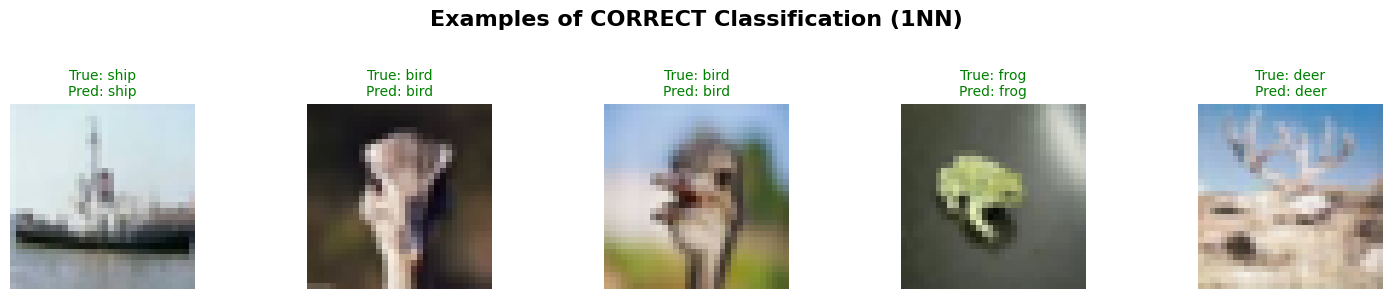

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/correct_examples_1NN.svg


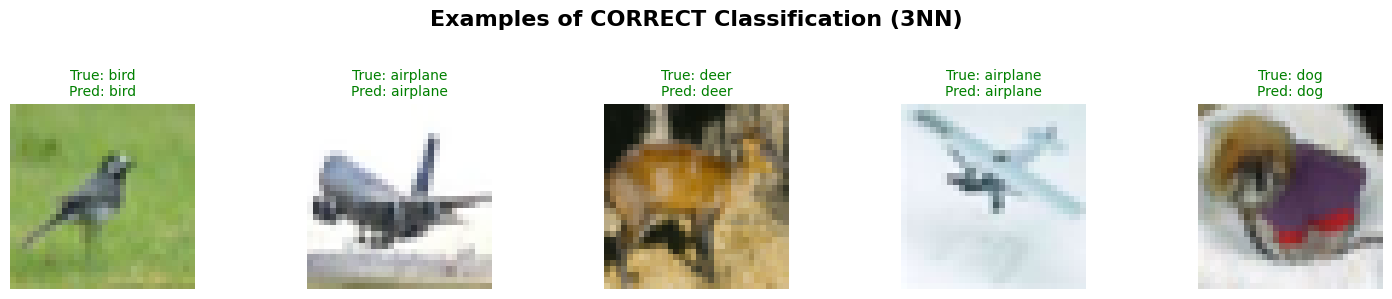

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/correct_examples_3NN.svg


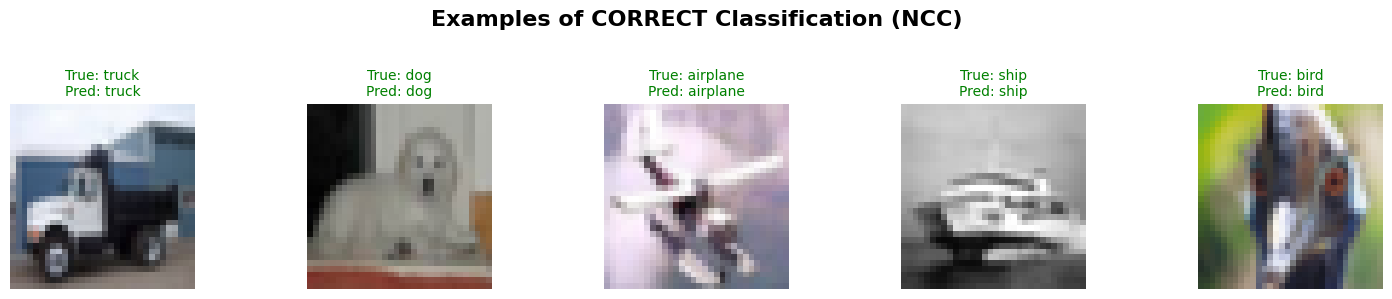

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/correct_examples_NCC.svg


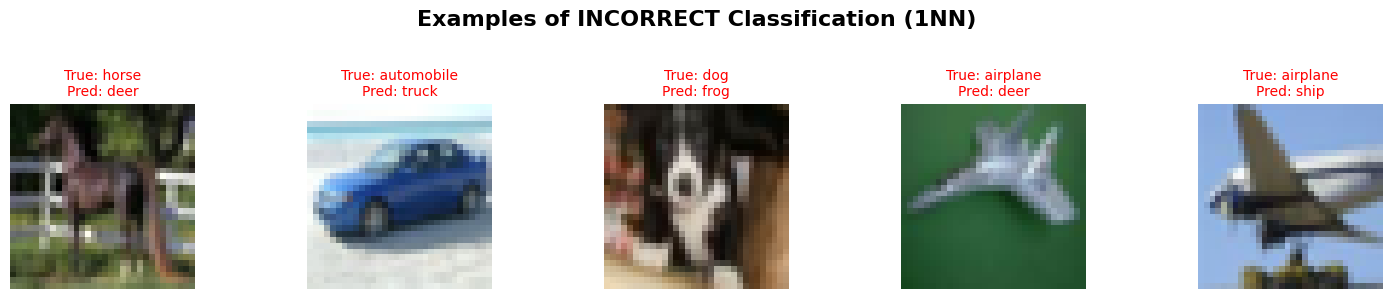

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/incorrect_examples_1NN.svg


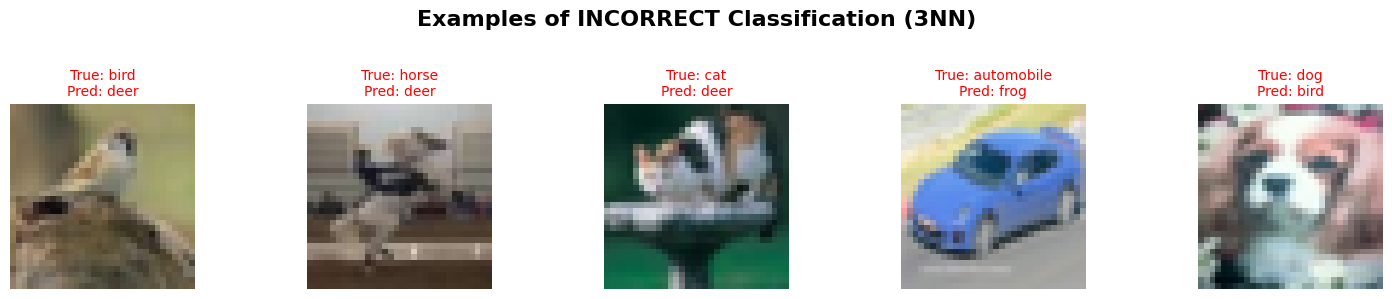

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/incorrect_examples_3NN.svg


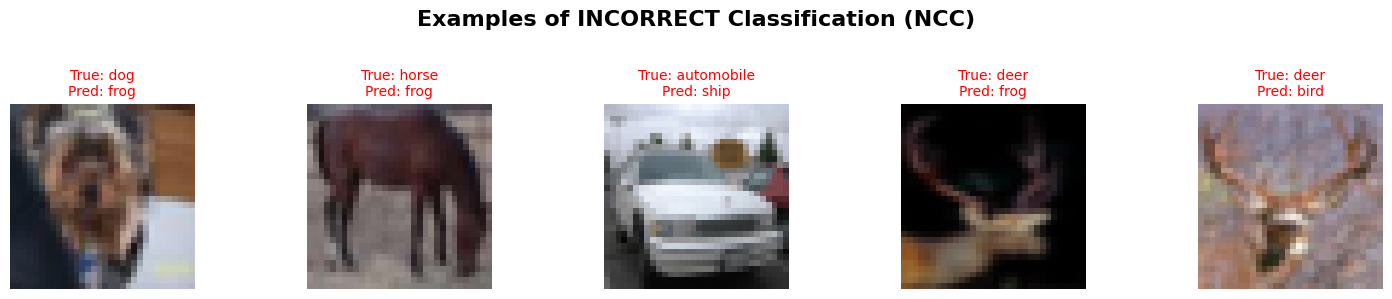

Saved to Google Drive: /content/drive/MyDrive/NeuralNetworks/Project1/incorrect_examples_NCC.svg


In [39]:
def show_classification_examples(X_test, y_test, y_pred, class_names,
                                 correct=True, n_examples=5,
                                 model_name="model"):

    """
    Shows examples of correct or incorrect classification and saves to Google Drive.
    Parameters:
        X_test: test images (N_test, H, W, C)
        y_test: true labels (N_test,)
        y_pred: predicted labels (N_test,)
        class_names: list of class names
        correct: True for correct classifications, False for incorrect
        n_examples: number of examples to show
        model_name: short name to identify which model produced results
    """

    # Choose which examples to display
    if correct:
        indices = np.where(y_test == y_pred)[0]
        title = f"Examples of CORRECT Classification ({model_name})"
        color = 'green'
        prefix = "correct"
    else:
        indices = np.where(y_test != y_pred)[0]
        title = f"Examples of INCORRECT Classification ({model_name})"
        color = 'red'
        prefix = "incorrect"

    # Randomly choose subset
    if len(indices) > n_examples:
        indices = np.random.choice(indices, n_examples, replace=False)

    # Create plot
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        axes[i].imshow(X_test[idx])
        axes[i].axis('off')
        axes[i].set_title(
            f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}",
            color=color,
            fontsize=10
        )

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    # Build filename (with timestamp for uniqueness)
    filename = f"{prefix}_examples_{model_name}.svg"
    full_path = f"{save_path}/{filename}"

    # Save and close figure
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"Saved to Google Drive: {full_path}")


print("\n" + "="*60)
print("CLASSIFICATION EXAMPLES")
print("="*60)

# Correct
show_classification_examples(X_test, y_test_eval, pred_1nn, class_names, correct=True, n_examples=5, model_name="1NN")
show_classification_examples(X_test, y_test_eval, pred_3nn, class_names, correct=True, n_examples=5, model_name="3NN")
show_classification_examples(X_test, y_test_eval, pred_ncc, class_names, correct=True, n_examples=5, model_name="NCC")

# Incorrect
show_classification_examples(X_test, y_test_eval, pred_1nn, class_names, correct=False, n_examples=5, model_name="1NN")
show_classification_examples(X_test, y_test_eval, pred_3nn, class_names, correct=False, n_examples=5, model_name="3NN")
show_classification_examples(X_test, y_test_eval, pred_ncc, class_names, correct=False, n_examples=5, model_name="NCC")



# **Συμπεράσματα**

In [38]:
print("\n" + "="*60)
print("EXPERIMENTS ANALYSIS")
print("="*60)

# 1. Distance Metrics
print("\nDISTANCE METRICS IMPACT (3-NN):")
print("-" * 50)
euclidean_acc = results['3-NN (Euclidean)']
manhattan_acc = results['3-NN (Manhattan)']
cosine_acc = results['3-NN (Cosine)']

print(f"Euclidean (L2):   {euclidean_acc:.2f}% ← baseline")
print(f"Manhattan (L1):   {manhattan_acc:.2f}% ({manhattan_acc - euclidean_acc:+.2f}%)")
print(f"Cosine (Angular): {cosine_acc:.2f}% ({cosine_acc - euclidean_acc:+.2f}%)")

distances_dict = {'Euclidean': euclidean_acc, 'Manhattan': manhattan_acc, 'Cosine': cosine_acc}
best_distance = max(distances_dict, key=distances_dict.get)
worst_distance = min(distances_dict, key=distances_dict.get)

print(f"\nBest: {best_distance} ({distances_dict[best_distance]:.2f}%)")
print(f"Worst: {worst_distance} ({distances_dict[worst_distance]:.2f}%)")
print(f"Range: {distances_dict[best_distance] - distances_dict[worst_distance]:.2f}%")

# 2. PCA Analysis
print("\nPCA DIMENSIONALITY REDUCTION (3-NN, Euclidean):")
print("-" * 50)
original_acc = results['3-NN (Euclidean)']

print(f"{'Components':<12} {'Accuracy':<12} {'Loss':<10} {'Expl.Var':<12} {'Reduction'}")
print("   " + "-" * 60)

for method in pca_methods:
    pca_info = pca_results[method]
    acc_loss = original_acc - pca_info['accuracy']
    reduction = (3072 - pca_info['n_components']) / 3072 * 100

    print(f"{pca_info['n_components']:<12} {pca_info['accuracy']:>6.2f}%     "
          f"{acc_loss:>5.2f}%    {pca_info['explained_var']:>6.1f}%      {reduction:>5.1f}%")

print(f"{'Original':<12} {original_acc:>6.2f}%     {'0.00%':<10} {'100.0%':<12} {'0.0%'}")
print("   " + "-" * 60)

# Best trade-off
best_pca = min(pca_results.items(),
               key=lambda x: original_acc - x[1]['accuracy'])
print(f"\nBest Trade-off: {best_pca[1]['n_components']} components")
print(f"Accuracy: {best_pca[1]['accuracy']:.2f}%")
print(f"Loss: -{original_acc - best_pca[1]['accuracy']:.2f}%")
print(f"Speedup: ~{3072 / best_pca[1]['n_components']:.1f}x faster")
print(f"Explained Variance: {best_pca[1]['explained_var']:.1f}%")

# 3. Overall Ranking
print("\nOVERALL PERFORMANCE RANKING:")
print("-" * 50)
sorted_methods = sorted(results.items(), key=lambda x: x[1], reverse=True)

for rank, (method, acc) in enumerate(sorted_methods, 1):
    medal = 'gold' if rank == 1 else 'silver' if rank == 2 else 'bronze' if rank == 3 else f'{rank}. '
    print(f"   {medal} {method:<30} {acc:>6.2f}%")

# 4. Key Findings
print("\nKEY FINDINGS & RECOMMENDATIONS:")
print("-" * 50)
print("Distance metrics have minimal impact (<2% variation)")
print("PCA offers significant speedup with acceptable accuracy loss")
print(f"Recommended: PCA with {best_pca[1]['n_components']} components")
print("3-NN consistently outperforms 1-NN (more robust)")
print("NCC is fastest but least accurate (good for baseline)")


EXPERIMENTS ANALYSIS

DISTANCE METRICS IMPACT (3-NN):
--------------------------------------------------
Euclidean (L2):   35.61% ← baseline
Manhattan (L1):   39.22% (+3.61%)
Cosine (Angular): 37.74% (+2.13%)

Best: Manhattan (39.22%)
Worst: Euclidean (35.61%)
Range: 3.61%

PCA DIMENSIONALITY REDUCTION (3-NN, Euclidean):
--------------------------------------------------
Components   Accuracy     Loss       Expl.Var     Reduction
   ------------------------------------------------------------
50            27.74%      7.87%      90.1%       98.4%
100           27.74%      7.87%      90.1%       96.7%
200           27.74%      7.87%      90.1%       93.5%
Original      35.61%     0.00%      100.0%       0.0%
   ------------------------------------------------------------

Best Trade-off: 50 components
Accuracy: 27.74%
Loss: -7.87%
Speedup: ~61.4x faster
Explained Variance: 90.1%

OVERALL PERFORMANCE RANKING:
--------------------------------------------------
   gold 3-NN (Manhattan)   